# Goal: Use multiple regression models to predict the age of a possum

## Dataset used: https://www.kaggle.com/datasets/abrambeyer/openintro-possum

In [ ]:
%%sql


# Get the Data

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# Need libomp for XGBoost to run
!pip install openpyxl
!pip install plotly
!pip install xlrd
!pip install seaborn
!pip install xgboost
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("./possum.csv")
df.head()

case  site  Pop sex  age  hdlngth  skullw  totlngth  taill  footlgth  \
0     1     1  Vic   m  8.0     94.1    60.4      89.0   36.0      74.5   
1     2     1  Vic   f  6.0     92.5    57.6      91.5   36.5      72.5   
2     3     1  Vic   f  6.0     94.0    60.0      95.5   39.0      75.4   
3     4     1  Vic   f  6.0     93.2    57.1      92.0   38.0      76.1   
4     5     1  Vic   f  2.0     91.5    56.3      85.5   36.0      71.0   

   earconch   eye  chest  belly  
0      54.5  15.2   28.0   36.0  
1      51.2  16.0   28.5   33.0  
2      51.9  15.5   30.0   34.0  
3      52.2  15.2   28.0   34.0  
4      53.2  15.1   28.5   33.0

In [4]:
df.shape

(104, 14)

In [5]:
df.ndim

2

In [6]:
df.describe()

case        site         age     hdlngth      skullw    totlngth  \
count  104.000000  104.000000  102.000000  104.000000  104.000000  104.000000   
mean    52.500000    3.625000    3.833333   92.602885   56.883654   87.088462   
std     30.166206    2.349086    1.909244    3.573349    3.113426    4.310549   
min      1.000000    1.000000    1.000000   82.500000   50.000000   75.000000   
25%     26.750000    1.000000    2.250000   90.675000   54.975000   84.000000   
50%     52.500000    3.000000    3.000000   92.800000   56.350000   88.000000   
75%     78.250000    6.000000    5.000000   94.725000   58.100000   90.000000   
max    104.000000    7.000000    9.000000  103.100000   68.600000   96.500000   

            taill    footlgth    earconch         eye       chest       belly  
count  104.000000  103.000000  104.000000  104.000000  104.000000  104.000000  
mean    37.009615   68.459223   48.130769   15.046154   27.000000   32.586538  
std      1.959518    4.395306    4.109380    1.050374    2.045597    2.761949  
min     32.000000   60.300000   40.300000   12.800000   22.000000   25.000000  
25%     35.875000   64.600000   44.800000   14.400000   25.500000   31.000000  
50%     37.000000   68.000000   46.800000   14.900000   27.000000   32.500000  
75%     38.000000   72.500000   52.000000   15.725000   28.000000   34.125000  
max     43.000000   77.900000   56.200000   17.800000   32.000000   40.000000

In [7]:
df.isnull().sum()

case        0
site        0
Pop         0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64

## There are 3 null values across age, my predictor, and footlgth, which is an issue

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df_age = df[df['age'].notna() & df['footlgth'].notna()]

df_age.shape

(101, 14)

## Since age is the predictor, traditionaly imputation using most common or mean values could actually skew the models I create. I have chosen to remove the threww rows instead in hopes of a more accurate final prediction

In [10]:
df_age.isnull().sum()

case        0
site        0
Pop         0
sex         0
age         0
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    0
earconch    0
eye         0
chest       0
belly       0
dtype: int64

In [11]:
df_age.keys()

Index(['case', 'site', 'Pop', 'sex', 'age', 'hdlngth', 'skullw', 'totlngth',
       'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly'],
      dtype='object')

## These keys are a little messy, let's clear things up

In [12]:
rename_dict = {
    'case': 'case',
    'site': 'site',
    'Pop': 'population',
    'sex': 'sex',
    'age': 'age',
    'hdlngth': 'head-length',
    'skullw': 'skull-width',
    'totlngth': 'total-length',
    'taill': 'tail-length',
    'footlgth': 'foot-length',
    'earconch': 'ear-conch',
    'eye': 'eye-diameter',
    'chest': 'chest-width',
    'belly': 'belly-girth'
}

df_age.rename(columns=rename_dict, inplace=True)
df_age.head()

case  site population sex  age  head-length  skull-width  total-length  \
0     1     1        Vic   m  8.0         94.1         60.4          89.0   
1     2     1        Vic   f  6.0         92.5         57.6          91.5   
2     3     1        Vic   f  6.0         94.0         60.0          95.5   
3     4     1        Vic   f  6.0         93.2         57.1          92.0   
4     5     1        Vic   f  2.0         91.5         56.3          85.5   

   tail-length  foot-length  ear-conch  eye-diameter  chest-width  belly-girth  
0         36.0         74.5       54.5          15.2         28.0         36.0  
1         36.5         72.5       51.2          16.0         28.5         33.0  
2         39.0         75.4       51.9          15.5         30.0         34.0  
3         38.0         76.1       52.2          15.2         28.0         34.0  
4         36.0         71.0       53.2          15.1         28.5         33.0

# Explore the Data

In [13]:
df_age.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 103
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   case          101 non-null    int64  
 1   site          101 non-null    int64  
 2   population    101 non-null    object 
 3   sex           101 non-null    object 
 4   age           101 non-null    float64
 5   head-length   101 non-null    float64
 6   skull-width   101 non-null    float64
 7   total-length  101 non-null    float64
 8   tail-length   101 non-null    float64
 9   foot-length   101 non-null    float64
 10  ear-conch     101 non-null    float64
 11  eye-diameter  101 non-null    float64
 12  chest-width   101 non-null    float64
 13  belly-girth   101 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.8+ KB


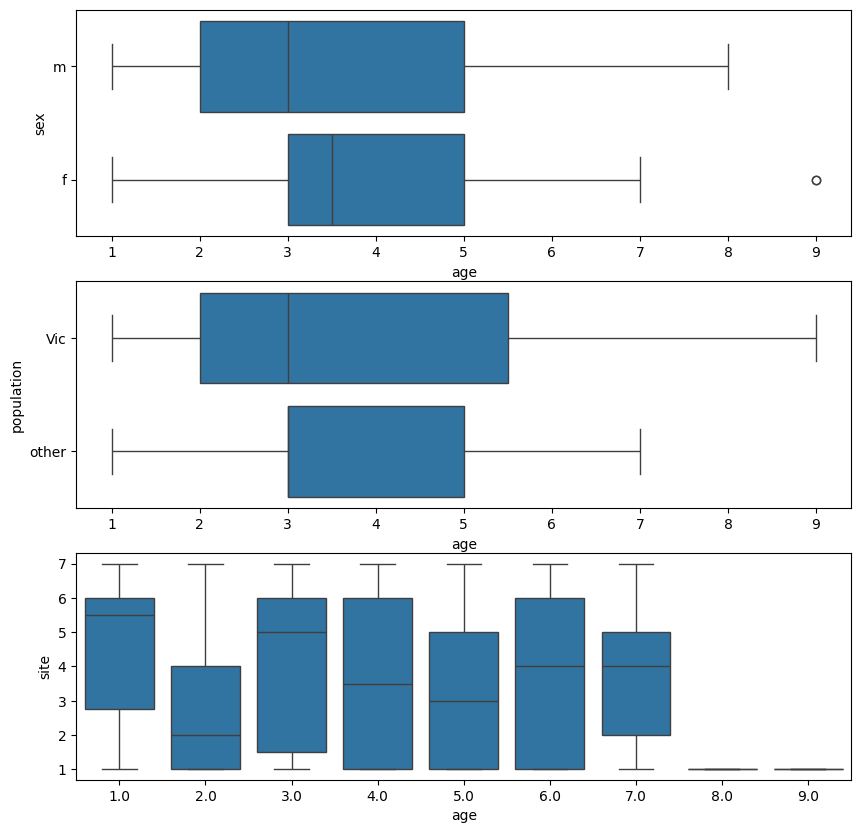

In [14]:
# Categorical columns
unique = ["sex", 'population', 'site']


fig, ax = plt.subplots(3, figsize=(10,10))
ax = ax.ravel()

for index, value in enumerate(unique):
    sns.boxplot(x='age', y=value, data=df_age, ax=ax[index])

## Observations
1. Based on sex, females contain one outlier while their median is more than that of males
2. Vic has more variations in age
3. Sites (y-axis) 2,4,6,7 all have outliers, furthermore site 6 has two outliers. Moreover, sites 1 and 5 have no outliers.
4. Site 5 has the highest median 

In [15]:
df_age.dtypes

case              int64
site              int64
population       object
sex              object
age             float64
head-length     float64
skull-width     float64
total-length    float64
tail-length     float64
foot-length     float64
ear-conch       float64
eye-diameter    float64
chest-width     float64
belly-girth     float64
dtype: object

## Population and sex are both string objects that I need to change for the model, but also to visualize. Population contains two values, as does sex - I can map int values to the two different objects

In [16]:
df_age['sex'] = df_age['sex'].map({'m': 0, 'f': 1})
df_age['population'] = df_age['population'].map({'Vic': 0, 'other': 1})

df_age.head()

case  site  population  sex  age  head-length  skull-width  total-length  \
0     1     1           0    0  8.0         94.1         60.4          89.0   
1     2     1           0    1  6.0         92.5         57.6          91.5   
2     3     1           0    1  6.0         94.0         60.0          95.5   
3     4     1           0    1  6.0         93.2         57.1          92.0   
4     5     1           0    1  2.0         91.5         56.3          85.5   

   tail-length  foot-length  ear-conch  eye-diameter  chest-width  belly-girth  
0         36.0         74.5       54.5          15.2         28.0         36.0  
1         36.5         72.5       51.2          16.0         28.5         33.0  
2         39.0         75.4       51.9          15.5         30.0         34.0  
3         38.0         76.1       52.2          15.2         28.0         34.0  
4         36.0         71.0       53.2          15.1         28.5         33.0

In [17]:
df_age.dtypes

case              int64
site              int64
population        int64
sex               int64
age             float64
head-length     float64
skull-width     float64
total-length    float64
tail-length     float64
foot-length     float64
ear-conch       float64
eye-diameter    float64
chest-width     float64
belly-girth     float64
dtype: object

## This change enables us to use a heatmap and other tools

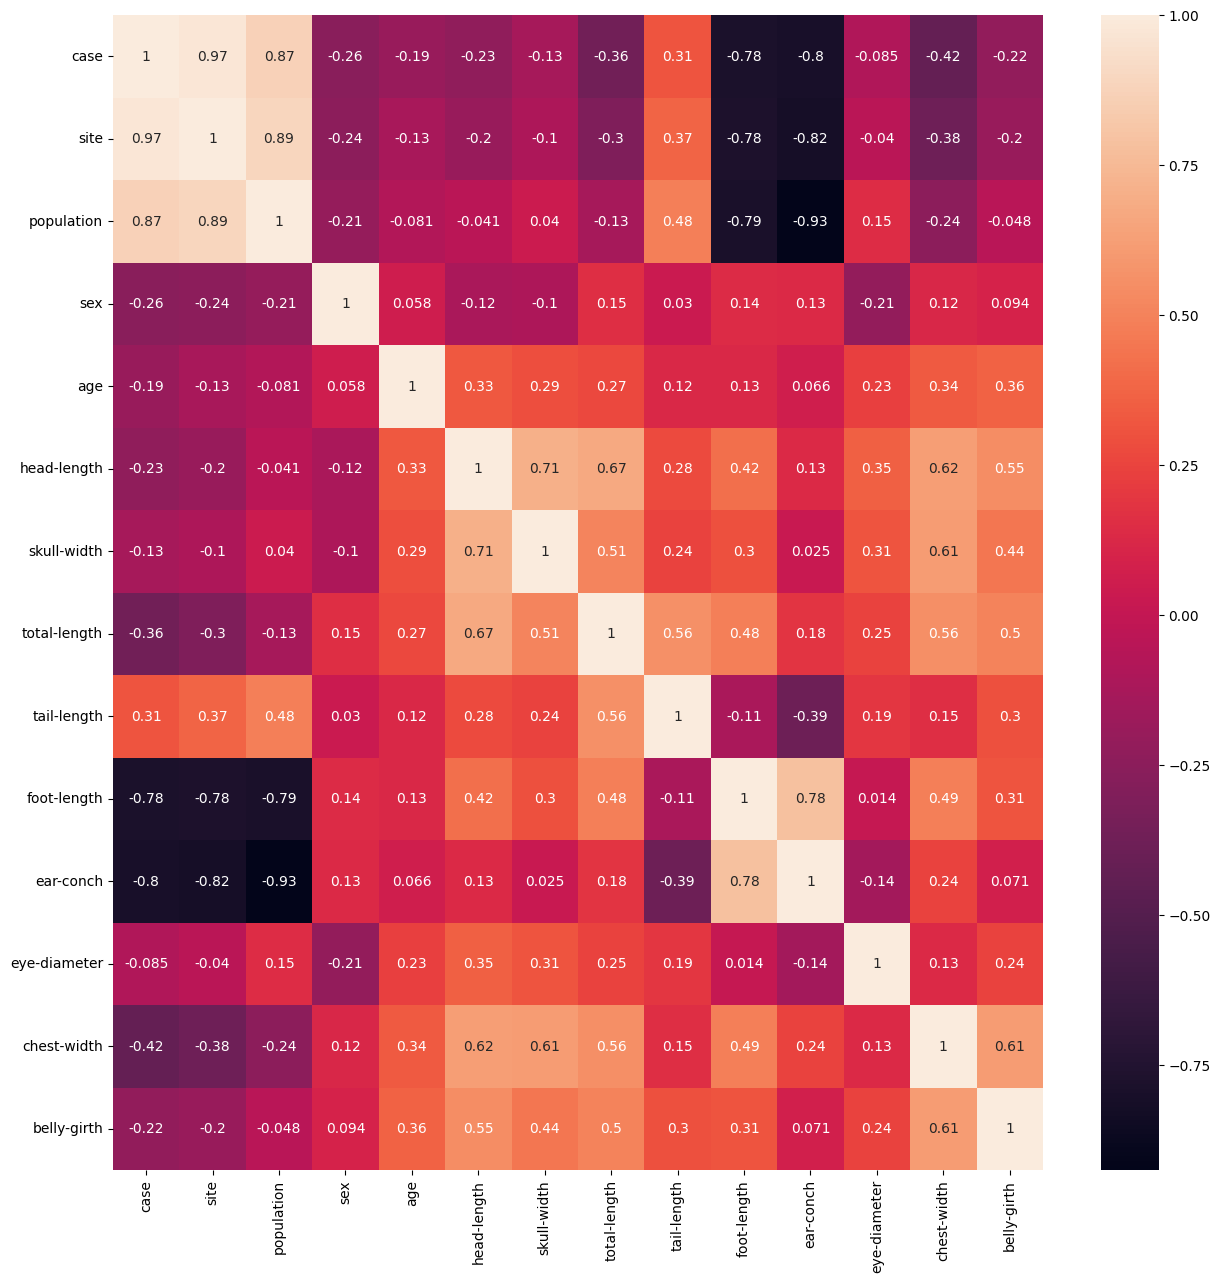

In [18]:
# Searching for correlations
plt.subplots(figsize=(15,15))
sns.heatmap(df_age.corr(),annot=True)
plt.show()

## Using the target variable, age, I can see that it correlates the most with head-length, chest-width and belly-girth. While not as strong as I expected, the indications are clear, as are the detractors. 

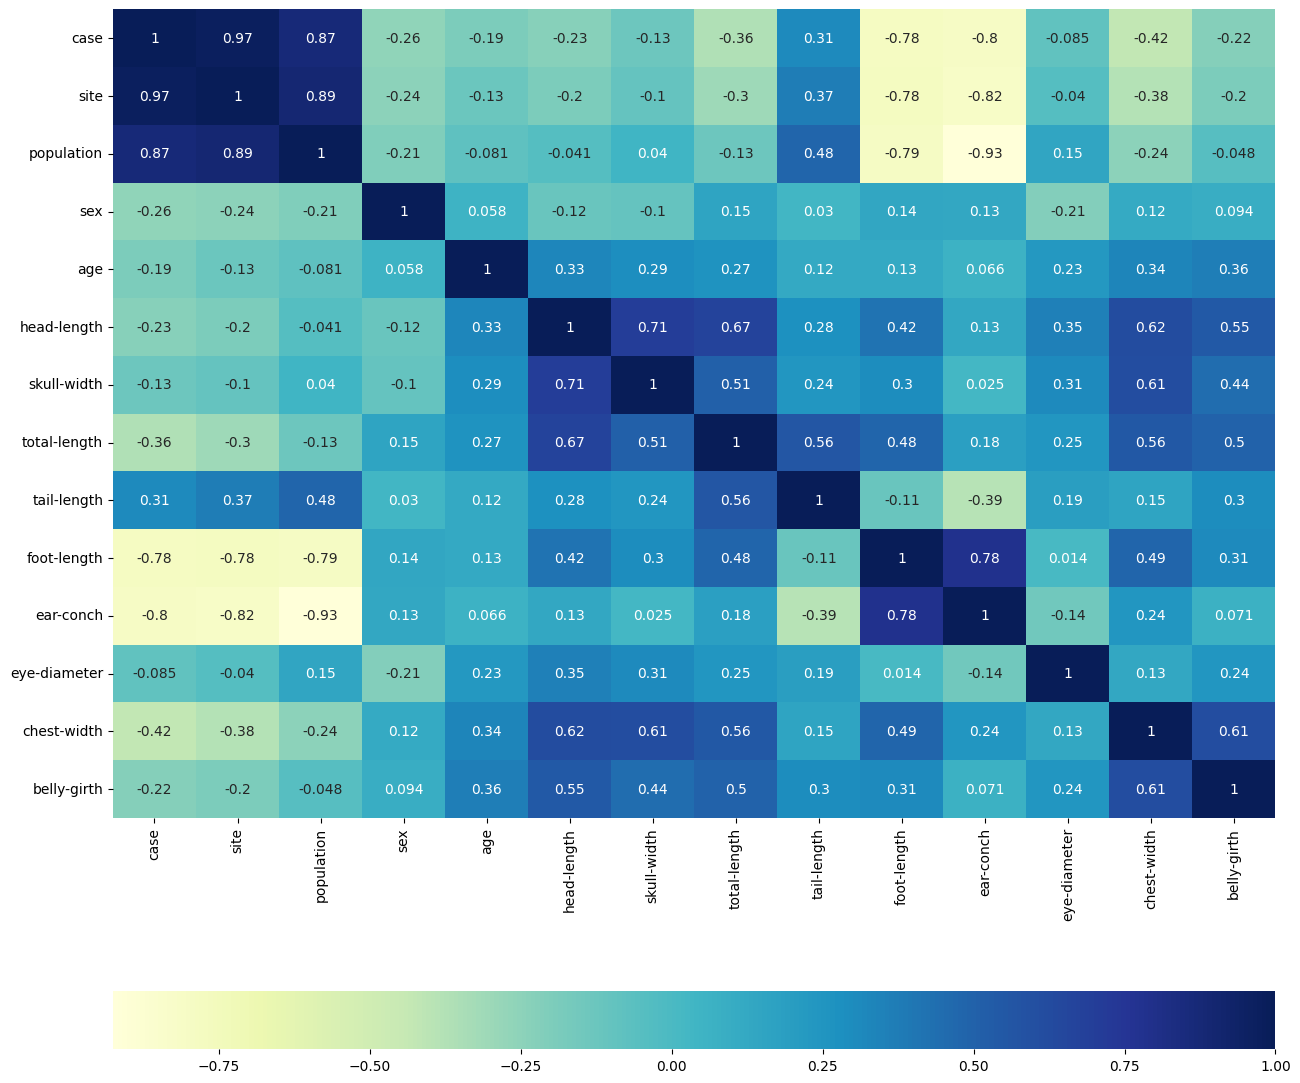

In [19]:
# Alternative map, same view
plt.subplots(figsize=(15,15))
sns.heatmap(df_age.corr(),annot=True, cmap="YlGnBu", cbar_kws= {"orientation": "horizontal"})
plt.show()

## Checking Skewness
Skew Levels:
1. (-0.5,0.5) = lowly skewed
2. (-1,0-0.5) U (0.5,1) = Moderately skewed
3. (-1 & beyond ) U (1 & beyond) = Highly skewed

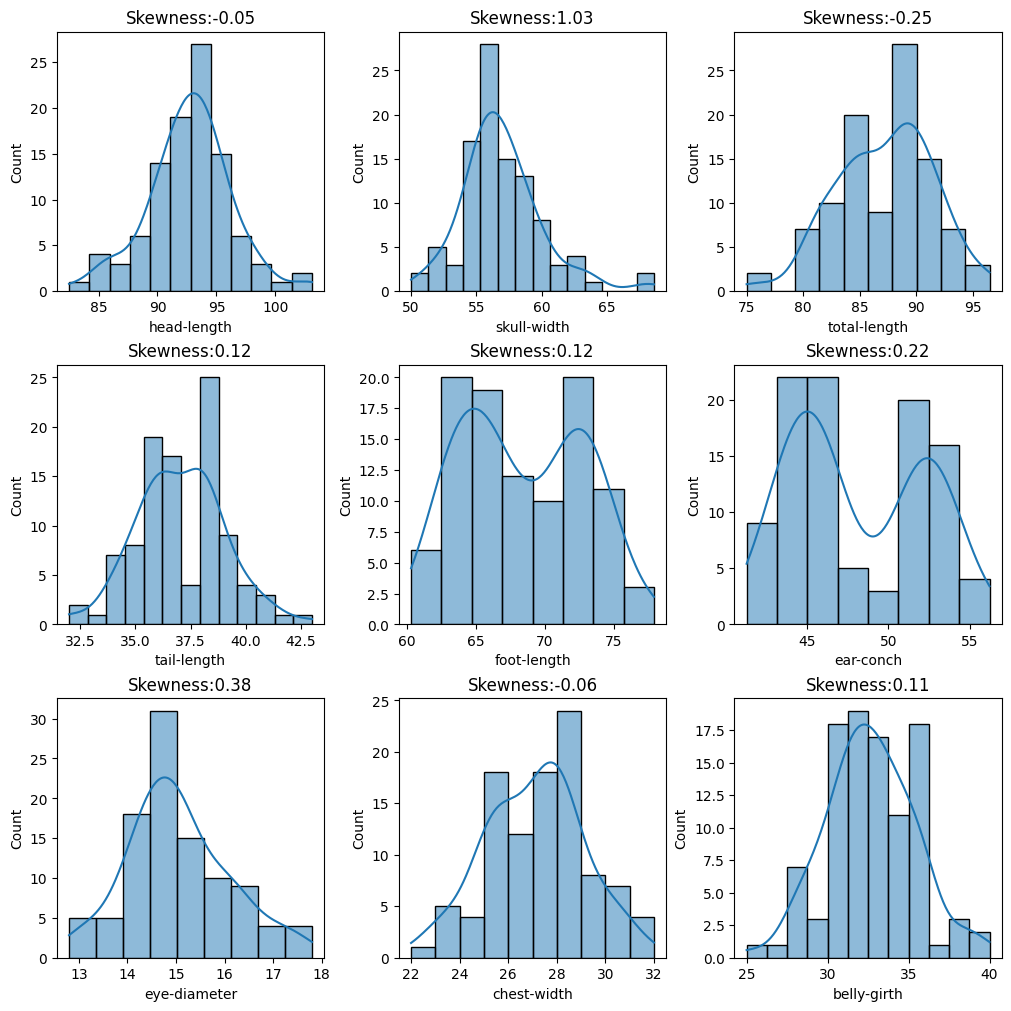

In [20]:
body = [
'head-length',
'skull-width',
'total-length',
'tail-length',
'foot-length',
'ear-conch',
'eye-diameter',
'chest-width',
'belly-girth']

fig, ax = plt.subplots(3,3, figsize=(10,10), constrained_layout=True)
ax = ax.ravel()


for index, value in enumerate(body):
    sns.histplot(x=value, data=df_age, ax=ax[index], kde=True)
    ax[index].set_title(f"Skewness:{np.around(df_age[value].skew(axis=0),2)}")


## head-length, total-length and eye-diamater have negative values for skewness
## skull-width has the highest overall skewness

<Axes: xlabel='site', ylabel='Count'>

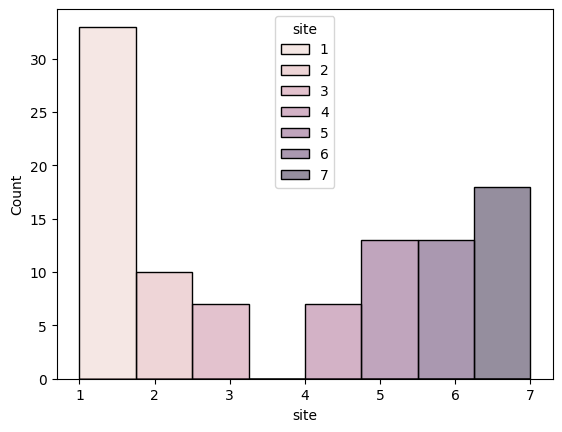

In [21]:
sns.histplot(data=df_age,x="site", kde=False, hue="site")

In [22]:
fig = px.pie(df_age,names="site")
fig.update_layout(
title={"x": 0.5, "xanchor":"center", 
"font_family":"Times New Roman", 
"text":"Site percentages"})
fig.show()

## Site 1 dominates the space

<Axes: xlabel='Pop', ylabel='Count'>

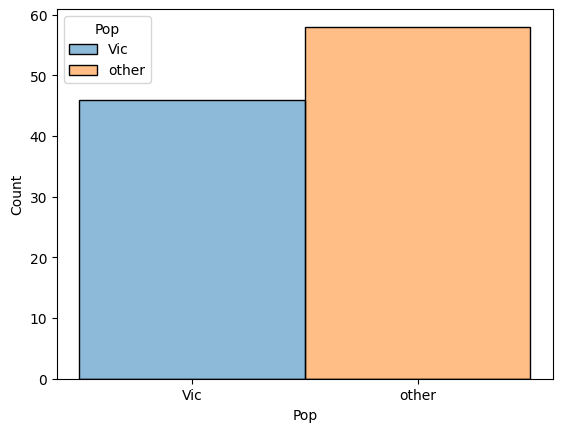

In [23]:
sns.histplot(data=df,x="Pop", kde=False, hue="Pop")

## Of the two population values, 'other' is greater than 'Vic'

<Axes: xlabel='sex', ylabel='Count'>

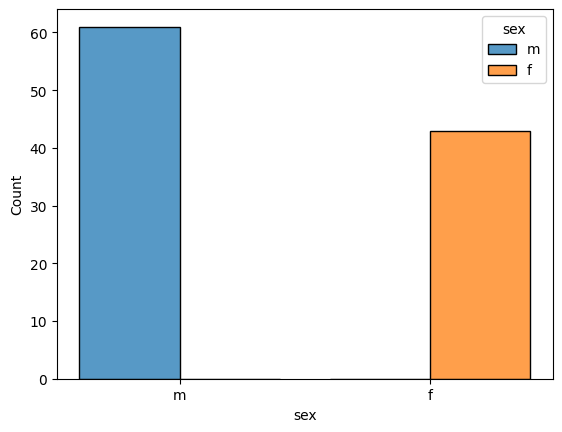

In [24]:
sns.histplot(data=df, x="sex", kde=False, hue="sex", multiple="dodge", shrink=.8)

## Note: using the original dataframe when categorical values are needed

In [25]:
fig = px.pie(df_age, names="sex")
fig.update_layout(
     title={
         "font_family": "New Times Roman",
         "font_size": 20,
         "text": "Male vs Female",
         "x": 0.5,
         "xanchor": "center",

    },
    showlegend=True,
    legend={
        "orientation": "h",
        "bgcolor": "darkblue",
        "font_color":"orange"
    }
)

fig.show()

## Males are greater than females by 16%, which can skew results

In [26]:
print("{}\n".format(df_age.sex.value_counts()))
print("{}\n".format(df_age.population.value_counts()))
print("{}".format(df_age.site.value_counts()))

sex
0    59
1    42
Name: count, dtype: int64

population
1    58
0    43
Name: count, dtype: int64

site
1    33
7    18
5    13
6    13
2    10
3     7
4     7
Name: count, dtype: int64


In [27]:
df_age['age'].nunique()

9

In [28]:
df_age.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 103
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   case          101 non-null    int64  
 1   site          101 non-null    int64  
 2   population    101 non-null    int64  
 3   sex           101 non-null    int64  
 4   age           101 non-null    float64
 5   head-length   101 non-null    float64
 6   skull-width   101 non-null    float64
 7   total-length  101 non-null    float64
 8   tail-length   101 non-null    float64
 9   foot-length   101 non-null    float64
 10  ear-conch     101 non-null    float64
 11  eye-diameter  101 non-null    float64
 12  chest-width   101 non-null    float64
 13  belly-girth   101 non-null    float64
dtypes: float64(10), int64(4)
memory usage: 11.8 KB


# Creating Training and Test Splits

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb

# Assuming df_age is the dataframe and age is the target column
X = df_age.drop(['age', 'case'], axis=1)  # Dropping 'case' and keeping 'age' as the target
y = df_age['age']  # Target variable is now treated as continuous

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Creating the Pipeline

In [30]:
pipe = Pipeline([
    ("preprocessing", StandardScaler()),  # Standard scaling
    ("regressor", RandomForestRegressor())  # Default model, will be tuned
])

# Define the parameter grid
params_grid = [
    {
        "preprocessing": [StandardScaler(), RobustScaler(), None], 
        "regressor": [LinearRegression()]
    },
    {
        "preprocessing": [StandardScaler(), RobustScaler(), None],
        "regressor": [RandomForestRegressor()],
        "regressor__n_estimators": [100, 200],
        "regressor__max_depth": [None, 5, 10]
    },
    {
        "preprocessing": [StandardScaler(), RobustScaler(), None],
        "regressor": [GradientBoostingRegressor()],
        "regressor__learning_rate": [0.01, 0.1, 0.2],
        "regressor__n_estimators": [100, 200],
        "regressor__max_depth": [3, 5, None]
    },
    {
        "preprocessing": [StandardScaler(), RobustScaler(), None],
        "regressor": [SVR()],
        "regressor__C": [0.1, 1, 10],
        "regressor__kernel": ['linear', 'rbf']
    },
    {
        "preprocessing": [None],
        "regressor": [xgb.XGBRegressor()],
        "regressor__learning_rate": [0.01, 0.1, 0.2],
        "regressor__n_estimators": [100, 200],
        "regressor__max_depth": [3, 5, None]
    }
]

In [31]:
grid = GridSearchCV(pipe, params_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'preprocessing': [StandardScaler(), RobustScaler(),
                                            None],
                          'regressor': [LinearRegression()]},
                         {'preprocessing': [StandardScaler(), RobustScaler(),
                                            None],
                          'regressor': [RandomForestRegressor()],
                          'regressor__max_depth': [N...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...)],
                          'regressor__learning_rate': [0.01, 0.1, 0.2],
                          'regressor__max_depth': [3, 5, None],
                          'regressor__n_estimators': [100, 200]}],
             scoring='r2')

In [32]:
print("Best model:\n{}\n", grid.best_estimator_)
print("Best R^2 score:\n{}\n", grid.best_score_)

# Displaying using the pandas format
results = pd.DataFrame(grid.cv_results_)
display(results.T)

Best model:
{}
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('regressor', GradientBoostingRegressor(learning_rate=0.01))])
Best R^2 score:
{}
 0.1896906024429923


0    \
mean_fit_time                                                            0.002311   
std_fit_time                                                             0.000587   
mean_score_time                                                          0.001144   
std_score_time                                                           0.000649   
param_preprocessing                                              StandardScaler()   
param_regressor                                                LinearRegression()   
param_regressor__max_depth                                                    NaN   
param_regressor__n_estimators                                                 NaN   
param_regressor__learning_rate                                                NaN   
param_regressor__C                                                            NaN   
param_regressor__kernel                                                       NaN   
params                          {'preprocessing': StandardScaler(), 'regressor...   
split0_test_score                                                        -0.06015   
split1_test_score                                                        0.288035   
split2_test_score                                                        0.229822   
split3_test_score                                                        -0.31908   
split4_test_score                                                       -1.036394   
mean_test_score                                                         -0.179554   
std_test_score                                                           0.480443   
rank_test_score                                                                82   

                                                                              1    \
mean_fit_time                                                            0.003708   
std_fit_time                                                             0.001162   
mean_score_time                                                          0.001408   
std_score_time                                                           0.000702   
param_preprocessing                                                RobustScaler()   
param_regressor                                                LinearRegression()   
param_regressor__max_depth                                                    NaN   
param_regressor__n_estimators                                                 NaN   
param_regressor__learning_rate                                                NaN   
param_regressor__C                                                            NaN   
param_regressor__kernel                                                       NaN   
params                          {'preprocessing': RobustScaler(), 'regressor':...   
split0_test_score                                                        -0.06015   
split1_test_score                                                        0.288035   
split2_test_score                                                        0.229822   
split3_test_score                                                        -0.31908   
split4_test_score                                                       -1.036394   
mean_test_score                                                         -0.179554   
std_test_score                                                           0.480443   
rank_test_score                                                                81   

                                                                              2    \
mean_fit_time                                                            0.000834   
std_fit_time                                                             0.000142   
mean_score_time                                                          0.000502   
std_score_time                                                           0.000031   
param_preprocessing                                                          None

# Create the Model

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

final_pipeline = Pipeline([
    ("preprocessing", RobustScaler()),
    ("regressor", GradientBoostingRegressor(learning_rate=0.01, random_state=42))
])

# Train the pipeline on the training data
final_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Optional: Display predictions
print("\nSample Predictions:")
for actual, predicted in zip(y_test[:10], y_pred[:10]):
    print(f"Actual: {actual}, Predicted: {predicted:.2f}")

Model Performance on Test Set:
Mean Squared Error (MSE): 2.6110
Mean Absolute Error (MAE): 1.1382
R² Score: 0.3214

Sample Predictions:
Actual: 2.0, Predicted: 2.93
Actual: 2.0, Predicted: 3.39
Actual: 7.0, Predicted: 4.17
Actual: 6.0, Predicted: 4.43
Actual: 4.0, Predicted: 4.35
Actual: 3.0, Predicted: 2.77
Actual: 4.0, Predicted: 4.43
Actual: 5.0, Predicted: 3.44
Actual: 9.0, Predicted: 4.43
Actual: 8.0, Predicted: 4.28


# Model Metrics

## Mean Squared Error (MSE): 2.6110
	•	MSE measures the average squared difference between actual and predicted values.
	•	A lower MSE indicates better performance.
	•	For your task, an MSE of 2.6110 means that, on average, the squared difference between the actual and predicted ages is 2.6110.

## Mean Absolute Error (MAE): 1.1382
	•	MAE measures the average absolute difference between actual and predicted values.
	•	A value of 1.1382 indicates that, on average, the model’s predictions are off by about 1.14 years.

## R² Score: 0.3214
	•	R² represents the proportion of the variance in the target variable (age) that is explained by the model.
	•	An R² of 0.3214 means the model explains 32.14% of the variability in age based on the input features.
	•	While better than no predictive power (R² = 0), it indicates room for improvement.

# Additional Models

In [34]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np

# Scaling features
scalers = [("StandardScaler", StandardScaler()), ("RobustScaler", RobustScaler()), ("None", None)]

# Models to compare
models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=42),
    "SVR": SVR(C=1, kernel="rbf"),
    "XGBRegressor": xgb.XGBRegressor(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=42)
}

# Store results
results = []

for scaler_name, scaler in scalers:
    print(f"\nUsing Scaler: {scaler_name}")
    X_train_scaled, X_test_scaled = X_train, X_test
    
    # Apply scaler if it's not None
    if scaler is not None:
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    
    for model_name, model in models.items():
        # Train and predict
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store result
        results.append({
            "Scaler": scaler_name,
            "Model": model_name,
            "MSE": mse,
            "MAE": mae,
            "R2": r2
        })
        print(f"\nModel: {model_name}")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R² Score: {r2:.4f}")


Using Scaler: StandardScaler

Model: LinearRegression
Mean Squared Error (MSE): 3.9251
Mean Absolute Error (MAE): 1.4321
R² Score: -0.0201

Model: RandomForestRegressor
Mean Squared Error (MSE): 2.5329
Mean Absolute Error (MAE): 1.2162
R² Score: 0.3417

Model: GradientBoostingRegressor
Mean Squared Error (MSE): 2.7050
Mean Absolute Error (MAE): 1.2805
R² Score: 0.2970

Model: SVR
Mean Squared Error (MSE): 3.0953
Mean Absolute Error (MAE): 1.2595
R² Score: 0.1955

Model: XGBRegressor
Mean Squared Error (MSE): 2.6558
Mean Absolute Error (MAE): 1.3125
R² Score: 0.3098

Using Scaler: RobustScaler

Model: LinearRegression
Mean Squared Error (MSE): 3.9251
Mean Absolute Error (MAE): 1.4321
R² Score: -0.0201

Model: RandomForestRegressor
Mean Squared Error (MSE): 2.5369
Mean Absolute Error (MAE): 1.2246
R² Score: 0.3407

Model: GradientBoostingRegressor
Mean Squared Error (MSE): 2.6920
Mean Absolute Error (MAE): 1.2767
R² Score: 0.3004

Model: SVR
Mean Squared Error (MSE): 2.8822
Mean Absolut


All Results:
            Scaler                      Model       MSE       MAE        R2
0   StandardScaler           LinearRegression  3.925080  1.432136 -0.020128
1   StandardScaler      RandomForestRegressor  2.532946  1.216154  0.341687
2   StandardScaler  GradientBoostingRegressor  2.704979  1.280512  0.296976
3   StandardScaler                        SVR  3.095330  1.259519  0.195524
4   StandardScaler               XGBRegressor  2.655805  1.312513  0.309756
5     RobustScaler           LinearRegression  3.925080  1.432136 -0.020128
6     RobustScaler      RandomForestRegressor  2.536862  1.224615  0.340670
7     RobustScaler  GradientBoostingRegressor  2.691976  1.276749  0.300355
8     RobustScaler                        SVR  2.882228  1.243870  0.250909
9     RobustScaler               XGBRegressor  2.655805  1.312513  0.309756
10            None           LinearRegression  3.925080  1.432136 -0.020128
11            None      RandomForestRegressor  2.539496  1.215000  0.33998

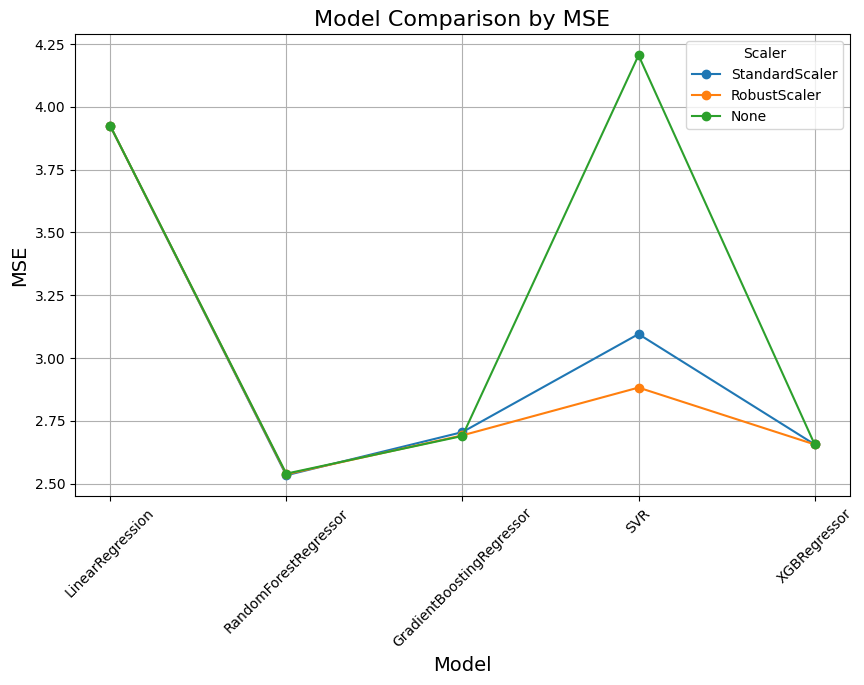

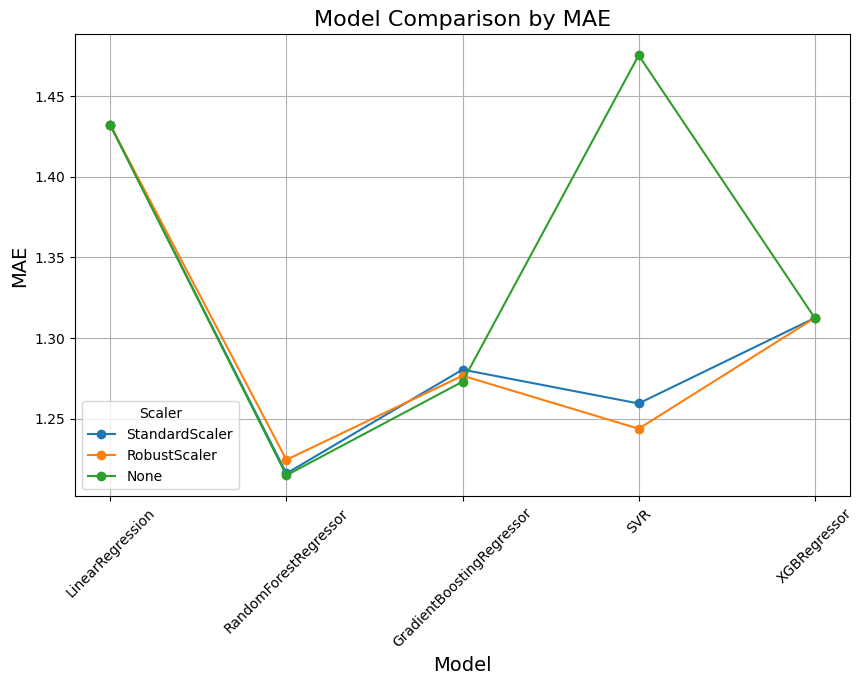

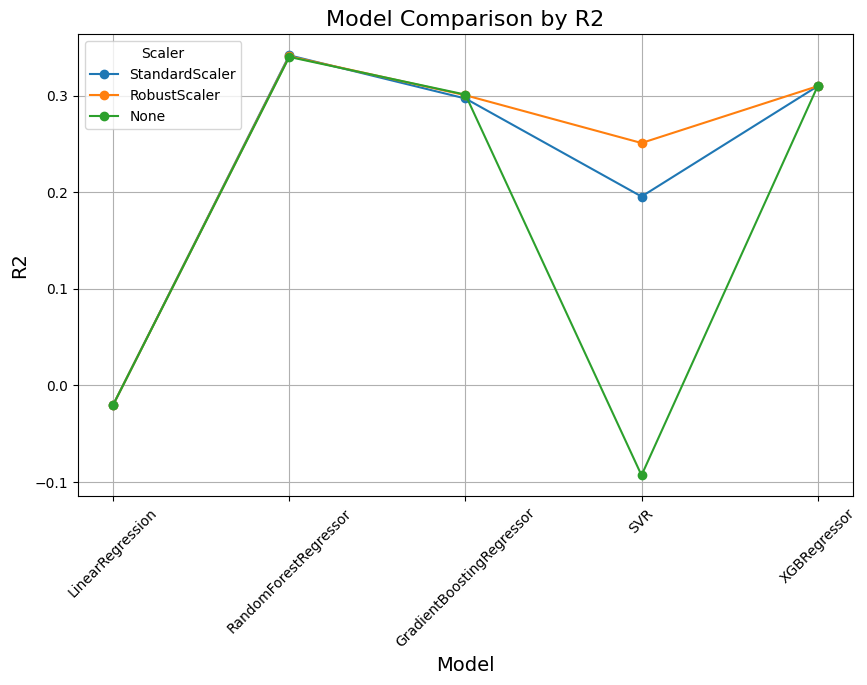

In [35]:
results_df = pd.DataFrame(results)
metrics = ['MSE', 'MAE', 'R2']

# Display the DataFrame (optional)
print("\nAll Results:")
print(results_df)

# Plot results for each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for scaler in results_df['Scaler'].unique():
        subset = results_df[results_df['Scaler'] == scaler]
        plt.plot(subset['Model'], subset[metric], marker='o', label=f'{scaler}')
    
    plt.title(f'Model Comparison by {metric}', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Scaler')
    plt.grid(True)
    plt.show()

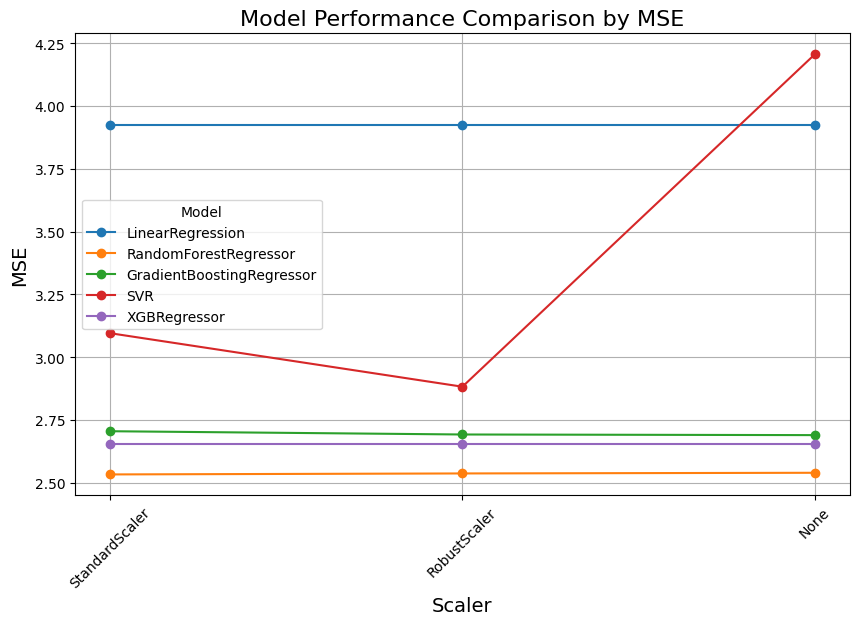

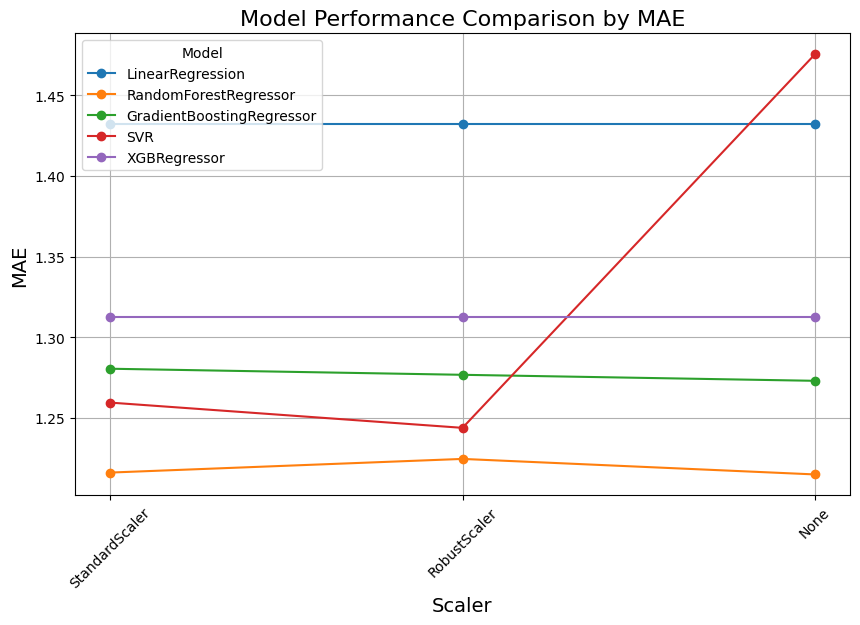

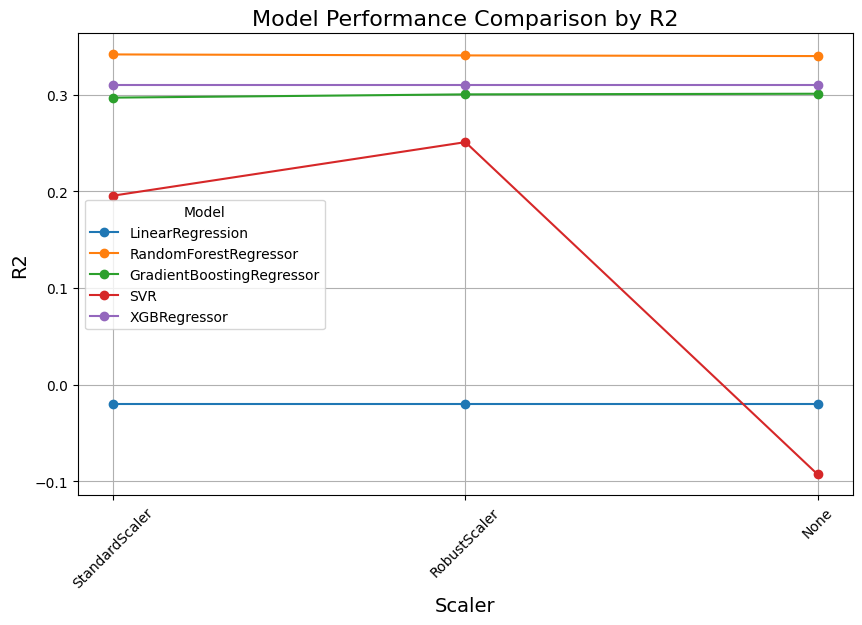

In [36]:
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for model in results_df['Model'].unique():
        subset = results_df[results_df['Model'] == model]
        plt.plot(subset['Scaler'], subset[metric], marker='o', label=f'{model}')
    
    plt.title(f'Model Performance Comparison by {metric}', fontsize=16)
    plt.xlabel('Scaler', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.grid(True)
    plt.show()

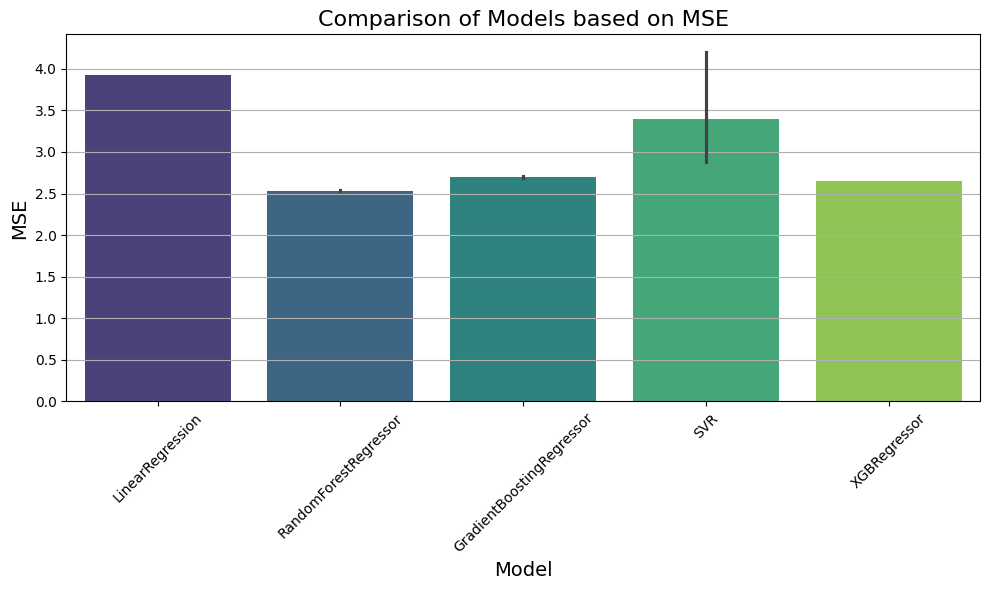

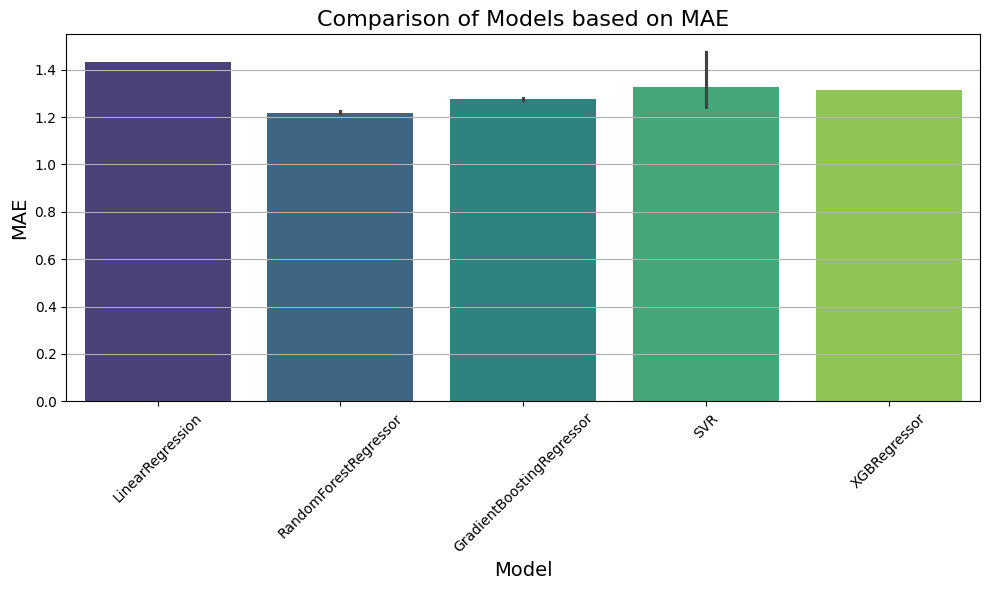

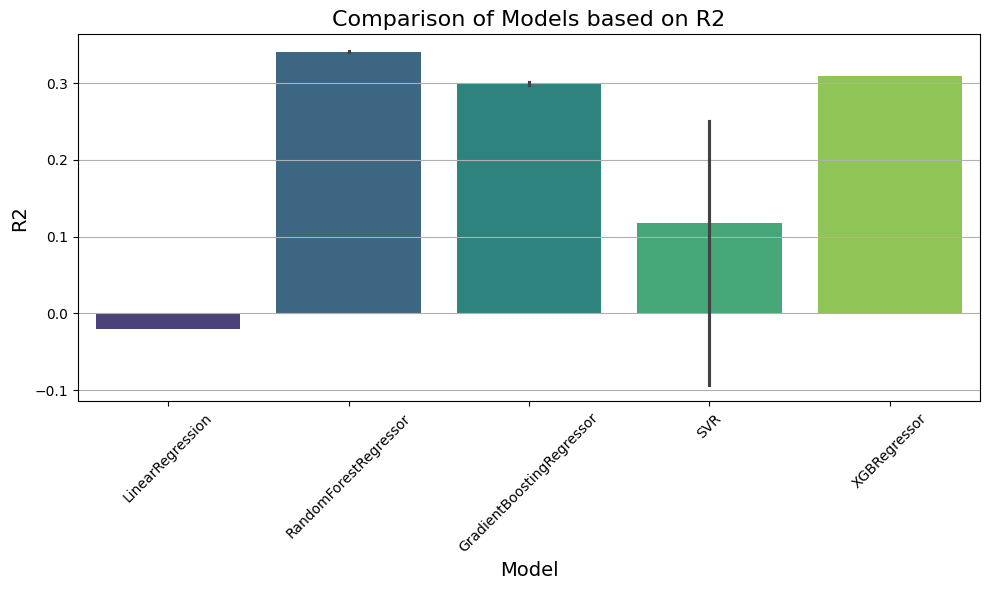

In [37]:
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y=metric, data=results_df, palette='viridis')
    plt.title(f'Comparison of Models based on {metric}', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


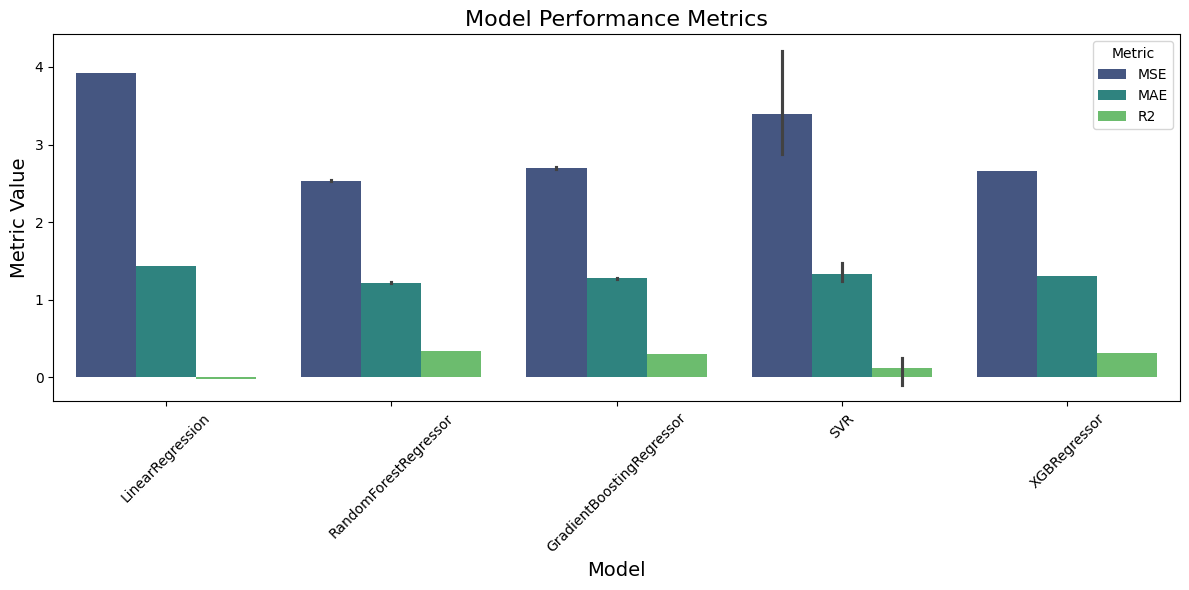

In [38]:
# Melt the DataFrame to a long format suitable for grouped bar charts
melted_results = results_df.melt(id_vars='Model', value_vars=['MSE', 'MAE', 'R2'],
                                 var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Value', hue='Metric', data=melted_results, palette='viridis')
plt.title('Model Performance Metrics', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


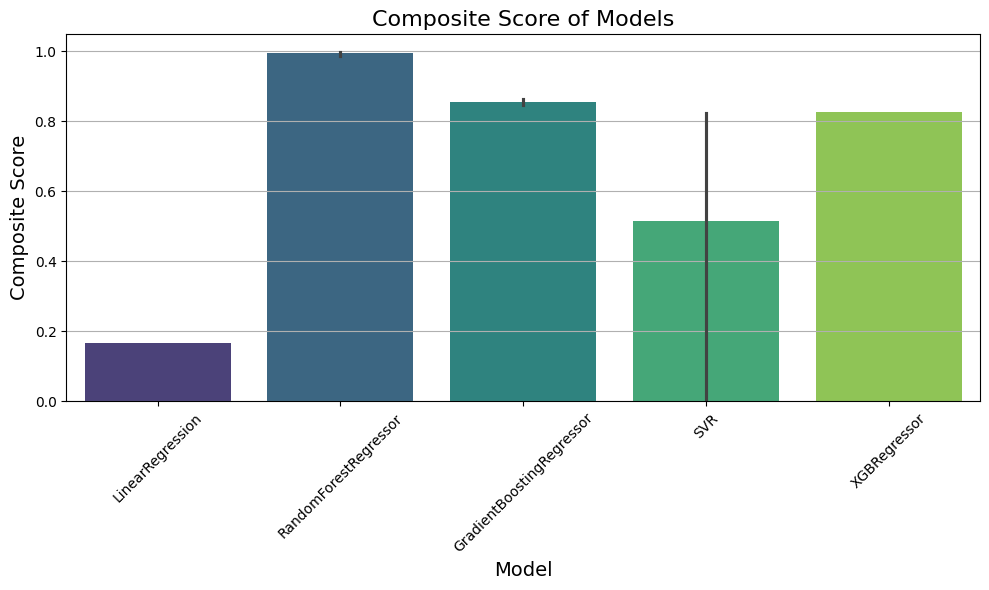

In [39]:
# Normalize metrics (assuming lower is better for MSE and MAE, higher is better for R2)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Normalize MSE and MAE to range [0,1], invert so that higher is better
results_df['MSE_norm'] = 1 - scaler.fit_transform(results_df[['MSE']])
results_df['MAE_norm'] = 1 - scaler.fit_transform(results_df[['MAE']])
# Normalize R2 to range [0,1]
results_df['R2_norm'] = scaler.fit_transform(results_df[['R2']])

# Compute composite score (average of normalized metrics)
results_df['Composite_Score'] = results_df[['MSE_norm', 'MAE_norm', 'R2_norm']].mean(axis=1)

# Plot composite scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Composite_Score', data=results_df, palette='viridis')
plt.title('Composite Score of Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Composite Score', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Creating Additional Datapoints

## As it stands, there currently is not enough data to accurately predict the age of possums.

## To attempt to resolve this issue, I can create synthetic data using bootstrap sampling

In [40]:
from sklearn.utils import resample
import pandas as pd

# Assuming X and y are your features and target
data = pd.concat([X, y], axis=1)

# Define the size of synthetic data
n_samples = 400  # Adjust based on your needs

# Create a bootstrap sample
synthetic_data = resample(data, replace=True, n_samples=n_samples, random_state=42)

# Separate the synthetic data into features and target
X_synthetic = synthetic_data.iloc[:, :-1]
y_synthetic = synthetic_data.iloc[:, -1]

# Combine with original data (if needed)
X_combined = pd.concat([X, X_synthetic])
y_combined = pd.concat([y, y_synthetic])

# Verify the sizes
print("Original data size:", X.shape)
print("Synthetic data size:", X_synthetic.shape)
print("Combined data size:", X_combined.shape)

Original data size: (101, 12)
Synthetic data size: (400, 12)
Combined data size: (501, 12)


In [41]:
X_train_synthetic, X_test_synthetic, y_train_synthetic, y_test_synthetic = train_test_split(X_combined, y_combined, random_state=42)

In [42]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np

# Scaling features
scalers = [("StandardScaler", StandardScaler()), ("RobustScaler", RobustScaler()), ("None", None)]

# Models to compare
models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=42),
    "SVR": SVR(C=1, kernel="rbf"),
    "XGBRegressor": xgb.XGBRegressor(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=42)
}

# Store results
synthetic_results = []

for scaler_name, scaler in scalers:
    print(f"\nUsing Scaler: {scaler_name}")
    X_train_scaled, X_test_scaled = X_train_synthetic, X_test_synthetic
    
    # Apply scaler if it's not None
    if scaler is not None:
        scaler.fit(X_train_synthetic)
        X_train_scaled = scaler.transform(X_train_synthetic)
        X_test_scaled = scaler.transform(X_test_synthetic)
    
    for model_name, model in models.items():
        # Train and predict
        model.fit(X_train_scaled, y_train_synthetic)
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate
        mse = mean_squared_error(y_test_synthetic, y_pred)
        mae = mean_absolute_error(y_test_synthetic, y_pred)
        r2 = r2_score(y_test_synthetic, y_pred)
        
        # Store result
        synthetic_results.append({
            "Scaler": scaler_name,
            "Model": model_name,
            "MSE": mse,
            "MAE": mae,
            "R2": r2
        })
        print(f"\nModel: {model_name}")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R² Score: {r2:.4f}")


Using Scaler: StandardScaler

Model: LinearRegression
Mean Squared Error (MSE): 3.1769
Mean Absolute Error (MAE): 1.4018
R² Score: 0.1941

Model: RandomForestRegressor
Mean Squared Error (MSE): 0.0856
Mean Absolute Error (MAE): 0.1402
R² Score: 0.9783

Model: GradientBoostingRegressor
Mean Squared Error (MSE): 0.1312
Mean Absolute Error (MAE): 0.2680
R² Score: 0.9667

Model: SVR
Mean Squared Error (MSE): 1.2977
Mean Absolute Error (MAE): 0.6880
R² Score: 0.6708

Model: XGBRegressor
Mean Squared Error (MSE): 0.2186
Mean Absolute Error (MAE): 0.3314
R² Score: 0.9446

Using Scaler: RobustScaler

Model: LinearRegression
Mean Squared Error (MSE): 3.1769
Mean Absolute Error (MAE): 1.4018
R² Score: 0.1941

Model: RandomForestRegressor
Mean Squared Error (MSE): 0.0870
Mean Absolute Error (MAE): 0.1410
R² Score: 0.9779

Model: GradientBoostingRegressor
Mean Squared Error (MSE): 0.1327
Mean Absolute Error (MAE): 0.2687
R² Score: 0.9663

Model: SVR
Mean Squared Error (MSE): 1.2553
Mean Absolute 


All Results:
            Scaler                      Model       MSE       MAE        R2
0   StandardScaler           LinearRegression  3.176860  1.401766  0.194123
1   StandardScaler      RandomForestRegressor  0.085574  0.140238  0.978292
2   StandardScaler  GradientBoostingRegressor  0.131205  0.267968  0.966717
3   StandardScaler                        SVR  1.297671  0.687953  0.670818
4   StandardScaler               XGBRegressor  0.218590  0.331351  0.944550
5     RobustScaler           LinearRegression  3.176860  1.401766  0.194123
6     RobustScaler      RandomForestRegressor  0.086988  0.141032  0.977934
7     RobustScaler  GradientBoostingRegressor  0.132701  0.268707  0.966338
8     RobustScaler                        SVR  1.255305  0.684498  0.681565
9     RobustScaler               XGBRegressor  0.218590  0.331351  0.944550
10            None           LinearRegression  3.176860  1.401766  0.194123
11            None      RandomForestRegressor  0.086426  0.140397  0.97807

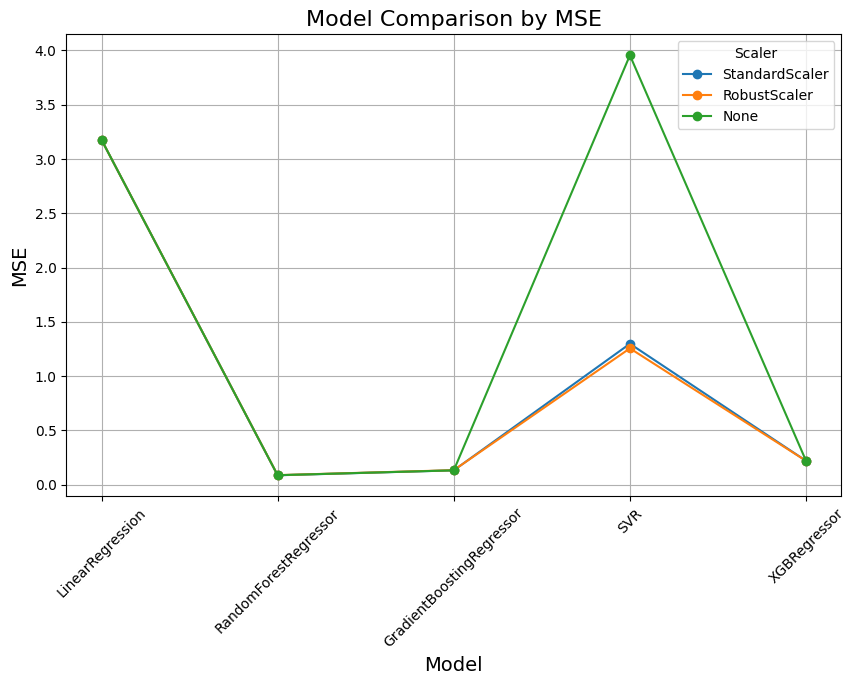

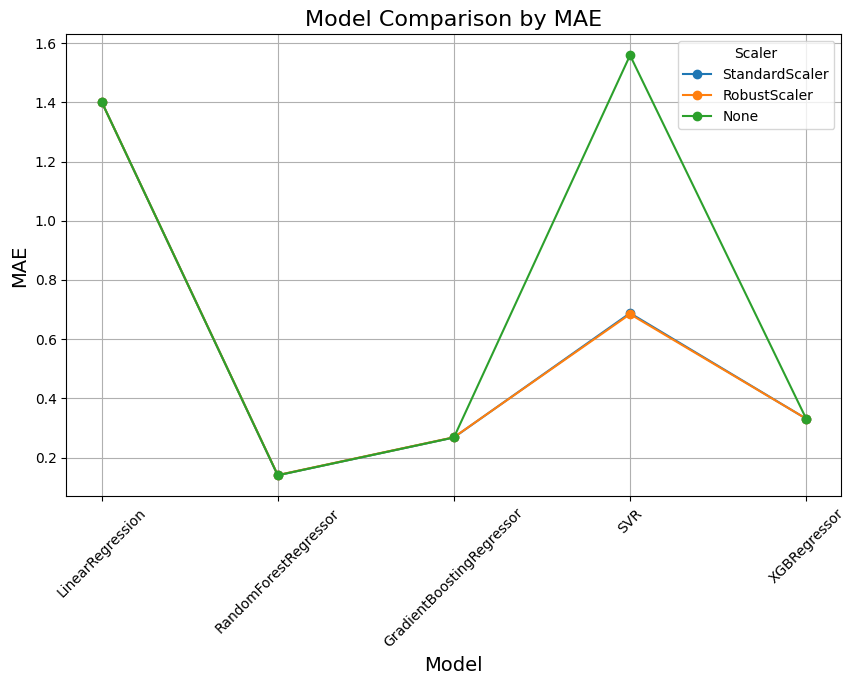

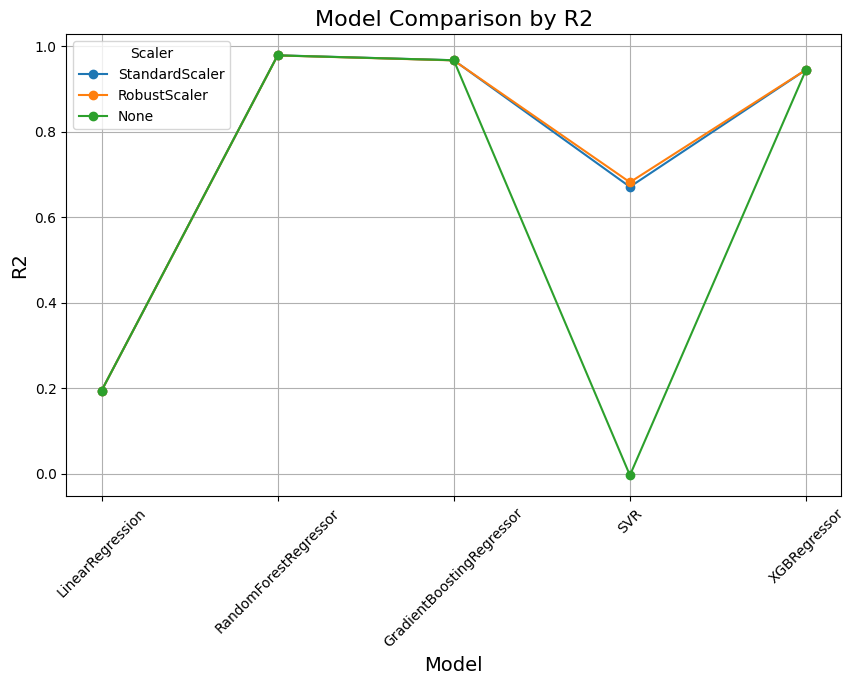

In [43]:
synthetic_results_df = pd.DataFrame(synthetic_results)

# Display the DataFrame (optional)
print("\nAll Results:")
print(synthetic_results_df)

# Plot results for each metric
for metric in ['MSE', 'MAE', 'R2']:
    plt.figure(figsize=(10, 6))
    for scaler in synthetic_results_df['Scaler'].unique():
        subset = synthetic_results_df[synthetic_results_df['Scaler'] == scaler]
        plt.plot(subset['Model'], subset[metric], marker='o', label=f'{scaler}')
    
    plt.title(f'Model Comparison by {metric}', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Scaler')
    plt.grid(True)
    plt.show()

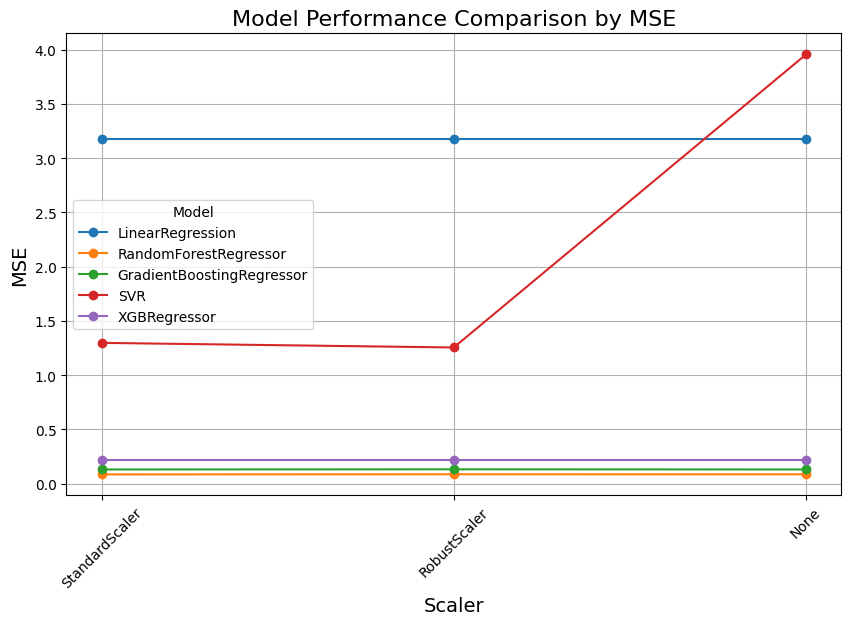

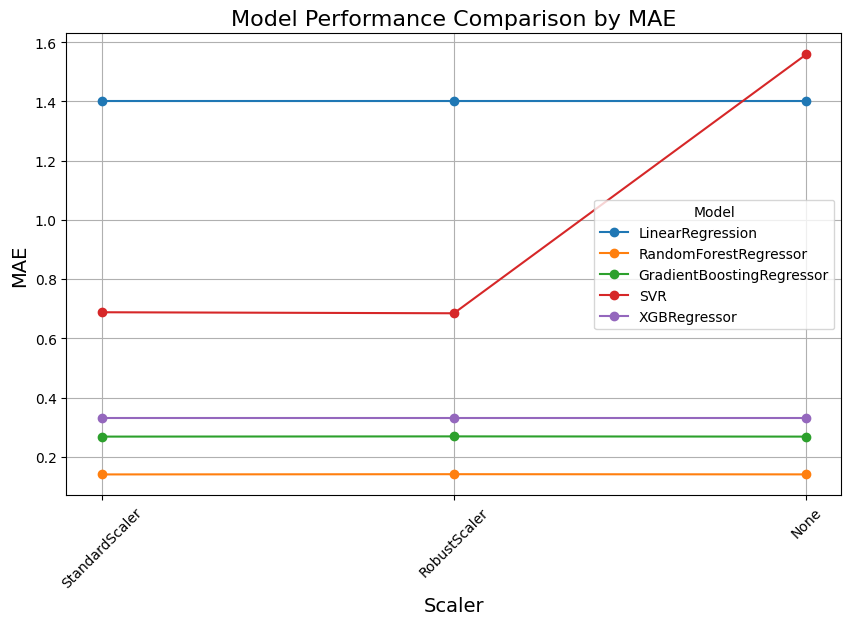

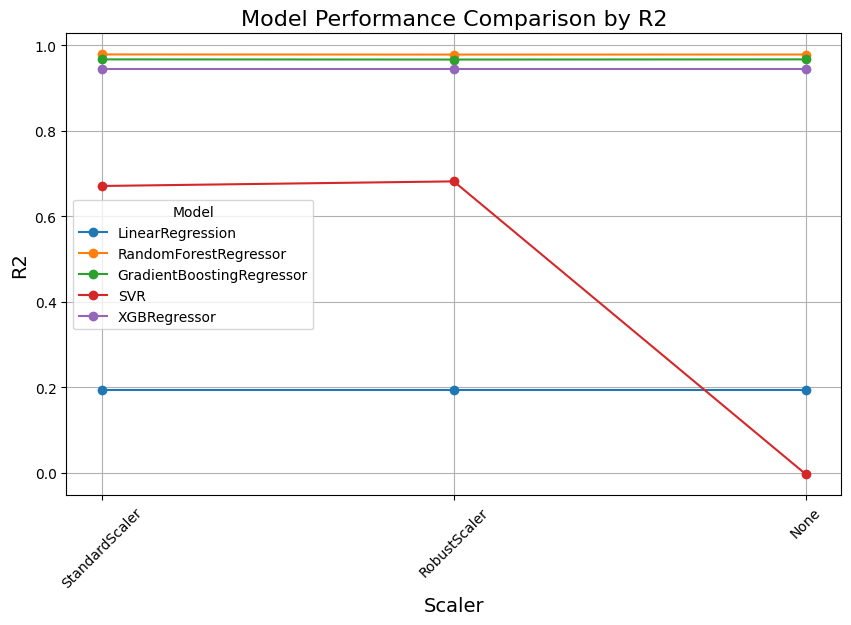

In [44]:
metrics = ['MSE', 'MAE', 'R2']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for model in synthetic_results_df['Model'].unique():
        subset = synthetic_results_df[synthetic_results_df['Model'] == model]
        plt.plot(subset['Scaler'], subset[metric], marker='o', label=f'{model}')
    
    plt.title(f'Model Performance Comparison by {metric}', fontsize=16)
    plt.xlabel('Scaler', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.grid(True)
    plt.show()

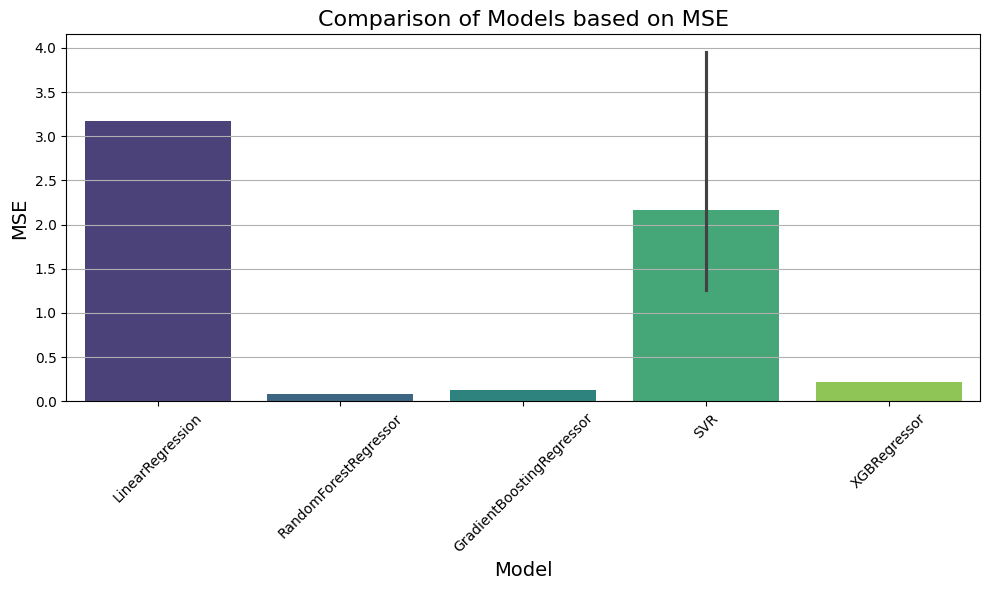

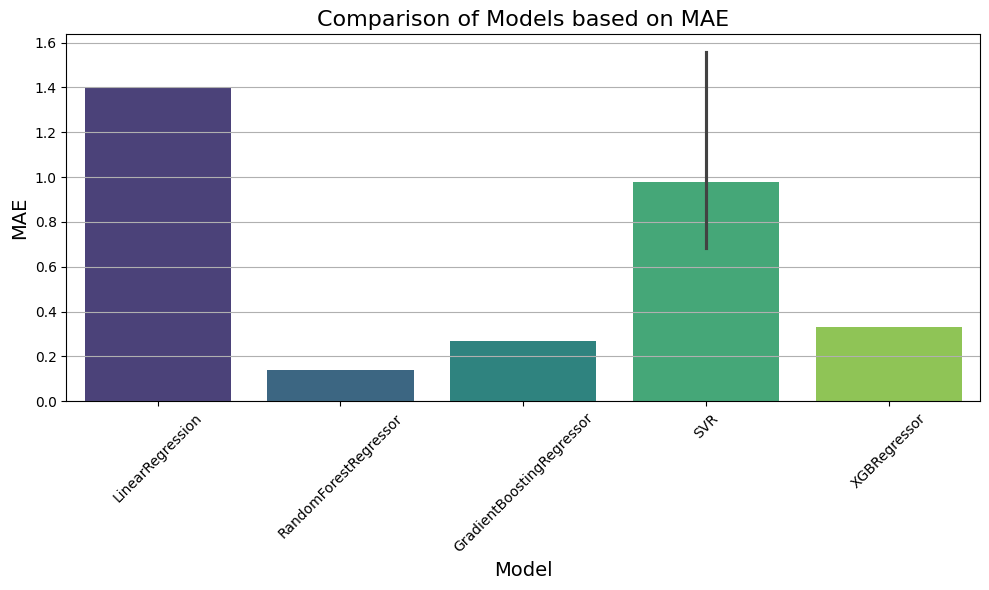

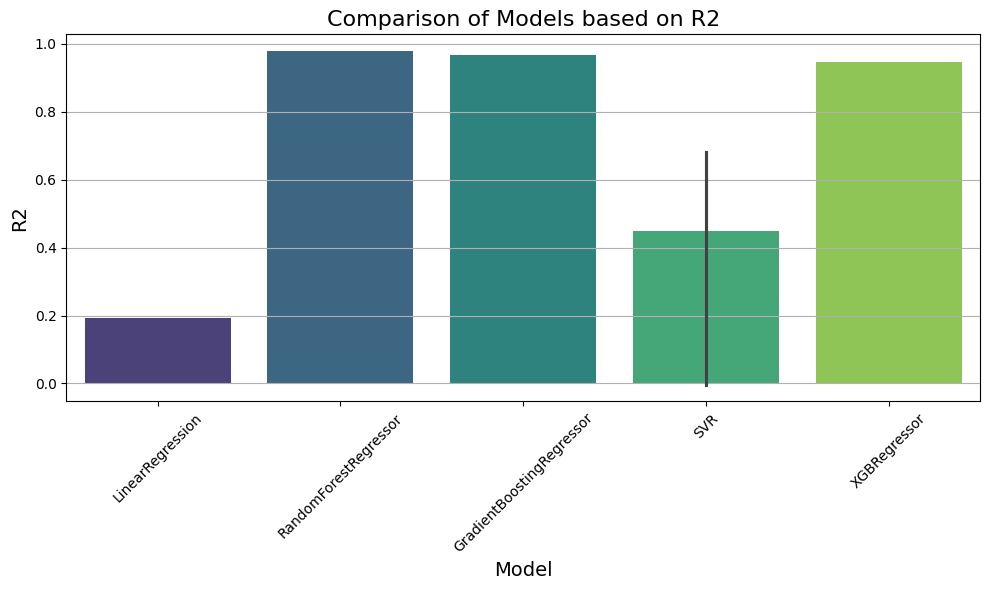

In [45]:
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y=metric, data=synthetic_results_df, palette='viridis')
    plt.title(f'Comparison of Models based on {metric}', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


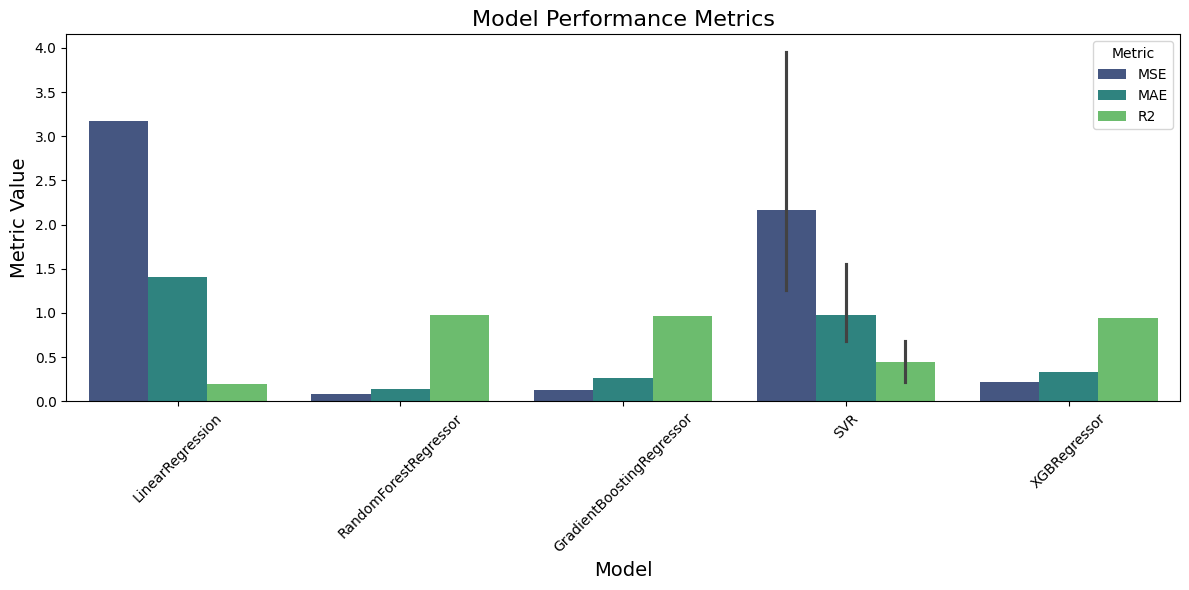

In [46]:
melted_results = synthetic_results_df.melt(id_vars='Model', value_vars=['MSE', 'MAE', 'R2'],
                                 var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Value', hue='Metric', data=melted_results, palette='viridis')
plt.title('Model Performance Metrics', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


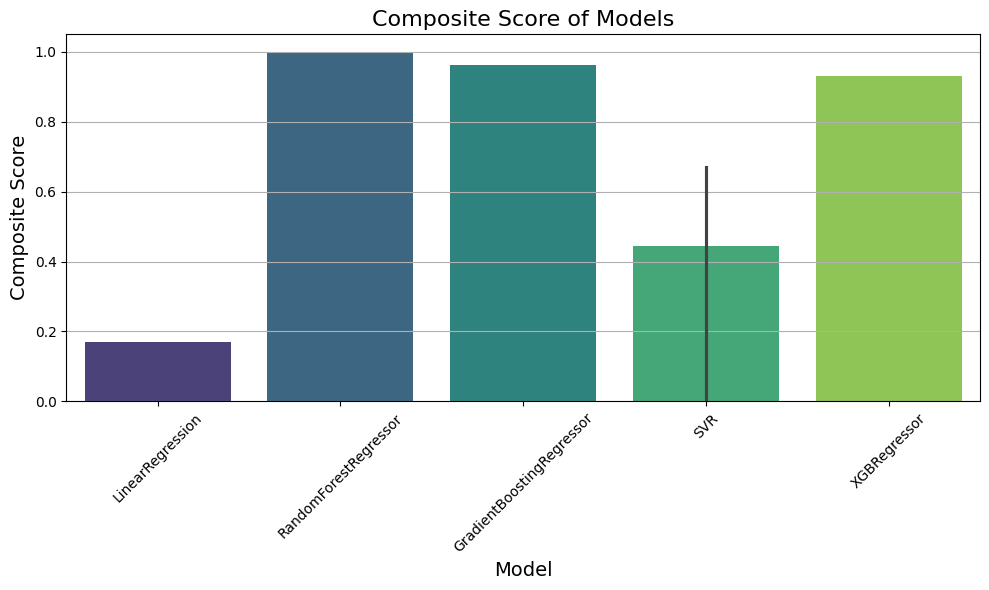

In [47]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Normalize MSE and MAE to range [0,1], invert so that higher is better
synthetic_results_df['MSE_norm'] = 1 - scaler.fit_transform(synthetic_results_df[['MSE']])
synthetic_results_df['MAE_norm'] = 1 - scaler.fit_transform(synthetic_results_df[['MAE']])
# Normalize R2 to range [0,1]
synthetic_results_df['R2_norm'] = scaler.fit_transform(synthetic_results_df[['R2']])

# Compute composite score (average of normalized metrics)
synthetic_results_df['Composite_Score'] = synthetic_results_df[['MSE_norm', 'MAE_norm', 'R2_norm']].mean(axis=1)

# Plot composite scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Composite_Score', data=synthetic_results_df, palette='viridis')
plt.title('Composite Score of Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Composite Score', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Conclusion

## Using regression to predict the age of possum based on identifiable metrics proved to be quite the challenge with such a small datset

## Using simple and advanced models with the dataset revealed some interesting behavior. For instance, Random Forest consistently beat out the competition even when using different scalers, while SVR struggled to compete - the initial models showed that there was a lot of variance when predicting for age, and while Linear Regression overfit to the mean values, SVR tried to remain flexible resulting in the worst scores overall. Interestingly Random Forest beat out the boosting models. At this stage I could not accurate predict the age of a possum.

## My method for creating synthetic data is crude - there are much better ways to do this, such as using TensorFlow, or Gaussian methods, however they require additional tooling that might be out of the scope of this project. Still, we get a glimpse into what happens with a bigger dataset: The more advanced models are able to stretch their legs and their predictions become significantly more accurate. Visually, we see that Linear Regerssion's problem persists - the manner in which it works is not fit for predicting varying age. However, Random Forest and the boosting models skyrocketed their scores. Using these models I am now able to predict the age of a possum.